# Deep Neural Networks 
## Session 25d

##  [Yolo V3](https://pjreddie.com/darknet/yolo/)

<img src='../../images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>


- Based on https://github.com/experiencor/keras-yolo3
- Additional Dataset https://cocodataset.org/#home

In [50]:
### Import Libraries

import tensorflow as tf

import os

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

from matplotlib.patches import Rectangle


import struct

from util.yolov3_util import decode_netout, WeightReader, correct_yolo_boxes, do_nms, make_yolov3_model

from tensorflow.keras.layers import Conv2D

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import add, concatenate
from tensorflow.keras.models import Model

# physical_devices = tf.config.list_physical_devices('GPU') 

# tf.config.experimental.set_memory_growth(physical_devices[0], True)

%matplotlib inline

In [51]:
# Some basic parameters

inpDir = 'input' # location where input data is stored
outDir = 'output' # location to store outputs
mdlDir = 'models' # location to store outputs
imgDir = 'yolo_images'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
EPOCHS = 100 # number of cycles to run

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,15),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large'
         }

plt.rcParams.update(params) # update rcParams

## Overview
The most salient feature of v3 is that it makes detections at three different scales.
### [Bounding box](http://christopher5106.github.io/object/detectors/2017/08/10/bounding-box-object-detectors-understanding-yolo.html)
YOLO v3 predicts boxes at 3 different scales. For the same image of 416 x 416, the number of predicted boxes are 10,647.

In [52]:
# define the labels
'''labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
          "boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
          "bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
          "backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
          "sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
          "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
          "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
          "chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
          "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
          "book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
'''
labels = ["person", "bicycle", "car", "motorbike", "pottedplant"]

# define the expected input shape for the model
input_w, input_h = 416, 416

# Anchor Size
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

# define the probability threshold for detected objects
class_threshold = 0.5 #0.7 # 0.3

nonmaxsup_threshold= 0.45 #0.45 #0.2

In [53]:
model = make_yolov3_model() # define the model

weight_reader = WeightReader(os.path.join(mdlDir, 'yolov3.weights')) # load the model weights

weight_reader.load_weights(model) # set the model weights into the model


model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']) # Compile the model

# save the model to file
model.save(os.path.join(mdlDir, 'yolo3_model.keras'))

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

In [54]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv_0 (Conv2D)                (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 bnorm_0 (BatchNormalization)   (None, None, None,   128         ['conv_0[0][0]']                 
                                32)                                                         

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file=os.path.join(outDir, 'model.png'),
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
    show_trainable=False
)

In [56]:
# load yolov3 model
model = tf.keras.models.load_model(os.path.join(mdlDir, 'yolo3_model.keras'))

In [57]:
# load and prepare an image
def load_image_pixels(filename, shape):
    
    # load the image to get its shape
    image = tf.keras.preprocessing.image.load_img(filename)
    width, height = image.size
    
    # load the image with the required size (Should not we be better off loading once????)
    image = tf.keras.preprocessing.image.load_img(filename, target_size=shape)
    
    # convert to a 3D Numpy array. 
    image = tf.keras.preprocessing.image.img_to_array(image)
    
    # scale values to between 0 and 1
    image = image.astype('float32')
    image /= 255.0
    
    #print ('before expand', image.shape, 'max pixel value', image.max())
    
    # add a dimension so that we have one sample
    image = tf.expand_dims(image, 0)
    #print ('after expand', image.shape)
    
    return image, width, height

In [58]:
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    
    # iterate all boxes
    for box in boxes:
        
        # iteratare all possible labels
        for i in range(len(labels)):
            
            # check if the threshold for this label is high enough to be listed
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100) # don't break, many labels may trigger for one box
                
    return v_boxes, v_labels, v_scores

In [59]:
# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    
    # load the image
    data = plt.imread(filename)
    
    # plot the image
    plt.imshow(data)
    
    # get the context for drawing boxes
    ax = plt.gca()

    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='white')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "{:s} ({:.0f}%)".format(v_labels[i], v_scores[i])
        plt.text(x1, y1, label, color='white')
        img_name = filename.split('/')[-1]      
        plt.savefig(os.path.join(outDir, img_name))
    
    # show the plot
    plt.show()

In [78]:
test_data_dir = os.path.join(inpDir, imgDir)
    
imgList = [f for f in os.listdir(test_data_dir) if os.path.isfile(os.path.join(test_data_dir, f))]

In [79]:
imgList

['Untitled.jpeg', '2007_000170.jpg', '2007_000129.jpg', '2007_000027.jpg']

In [84]:
# define our new photo
photo_filename = os.path.join(test_data_dir, imgList[0])


# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

# make prediction
y_pred = model.predict(image)

# summarize the shape of the list of arrays
print([a.shape for a in y_pred])

boxes = list()
for i in range(len(y_pred)):
    # decode the output of the network
    boxes += decode_netout(y_pred[i][0], anchors[i], class_threshold, nonmaxsup_threshold, input_h, input_w)

# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

# suppress non-maximal boxes
do_nms(boxes, nonmaxsup_threshold)

# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

# What did you find in the picture
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])

1/1 [==============================] - 1s 526ms/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
person 67.69339442253113
person 74.80638027191162
person 61.262041330337524
person 53.19334268569946
person 68.13904047012329
person 84.65825319290161
person 69.87770199775696
person 96.93627953529358
person 57.665395736694336
person 89.27698135375977
person 81.73112273216248
person 95.91076374053955
person 97.55597114562988
person 57.39887356758118
person 87.84719705581665
person 60.81538200378418
person 85.0122332572937
person 79.21862006187439
person 70.34806609153748
person 72.90845513343811
person 92.84319281578064
person 89.89109992980957
person 99.74799156188965


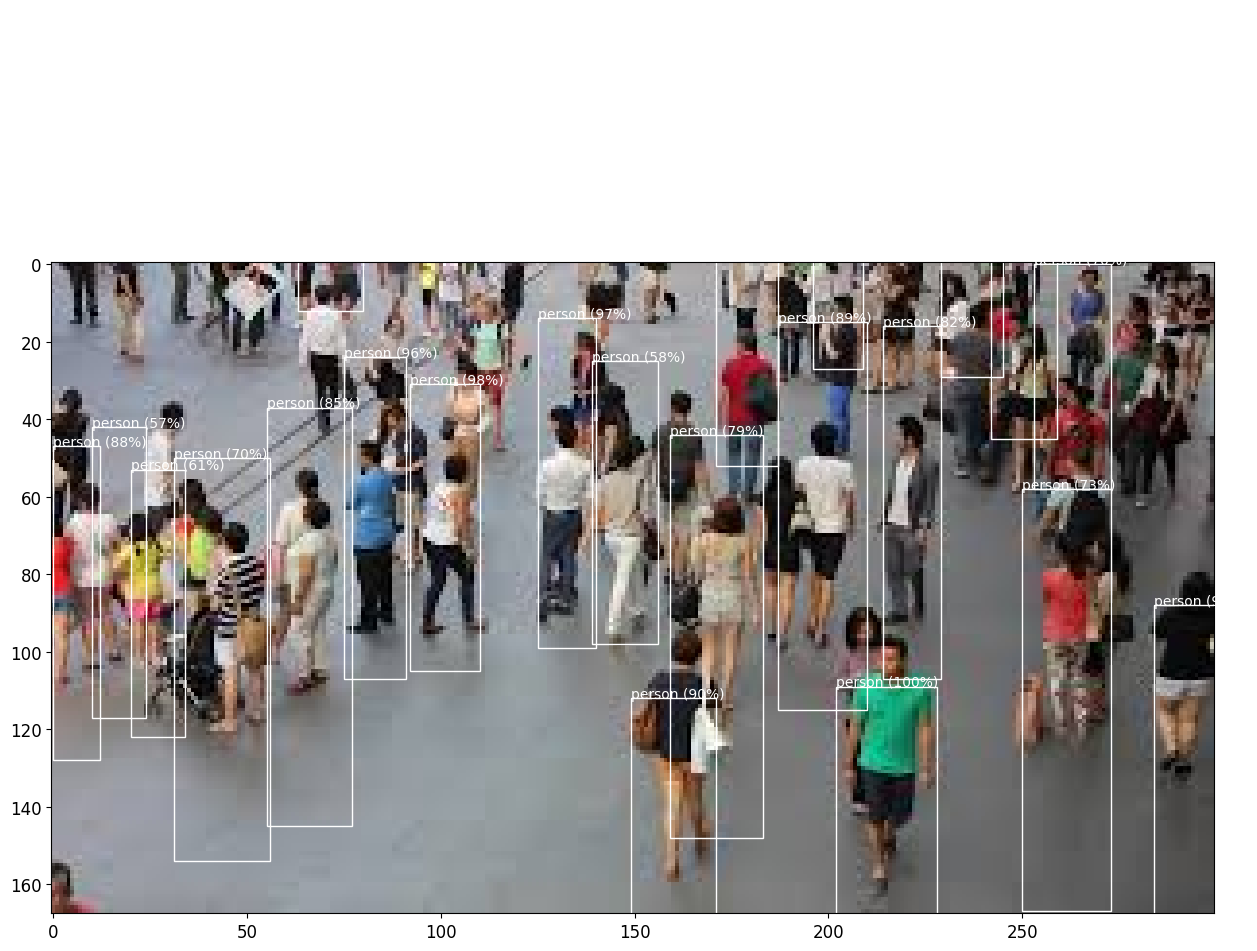

In [85]:
draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

In [86]:
#x, y, w, h = netout[int(row)][int(col)][b][:4]
x, y, w, h = y_pred[0][0][0][0][:4]
x, y, w, h

(0.59886247, 0.69865996, 0.35908198, -0.5107151)

In [87]:
y_pred[1][0][0][0][:4]

array([ 0.56566924,  0.8231324 , -0.27493984, -0.14238611], dtype=float32)